# DCGAN for CIFAR-10 trained image generator:

#### Yassin Bahid

DCGAN is a type of GAN that uses convolutional neural networks (CNNs) for both the generator and discriminator, making it an effective model for image generation. We train a DCGAN model on the CIFAR-10 dataset and evaluate the quality of the generated images. Our results demonstrate that DCGAN is capable of generating high-quality images with good diversity and can learn from small datasets. However, we also note that DCGAN can be difficult to train and sensitive to hyperparameters. DCGAN is a promising model for image generation tasks on CIFAR-10 and other similar datasets.

## 1 - Introduction:


DCGAN stands for Deep Convolutional Generative Adversarial Network. It is a type of Generative Adversarial Network (GAN) that uses convolutional neural networks (CNNs) to generate high-quality images. DCGANs were introduced in 2015 by Alec Radford et al. and have since become a popular approach for generating realistic images.

The key idea behind DCGANs is to use convolutional layers instead of fully connected layers in both the generator and discriminator networks. This allows the networks to learn hierarchical features that are important for image generation, such as edges, shapes, and textures. Additionally, DCGANs use several best practices to stabilize training and improve the quality of generated images, including:
- Strided convolutions instead of pooling layers for downsampling in the discriminator
- Transposed convolutions instead of upsampling layers in the generator
- Batch normalization in both the generator and discriminator
- ReLU activation function in the generator except for the output layer, which uses Tanh
- LeakyReLU activation function in the discriminator
- Strided convolutions instead of pooling layers for downsampling in the discriminator
- Transposed convolutions instead of upsampling layers in the generator

DCGANs are trained using a similar framework as other GANs. The generator is trained to generate images that are similar to real images, while the discriminator is trained to distinguish between real and fake images. The generator and discriminator are trained in alternating fashion, with the generator trying to fool the discriminator and the discriminator trying to correctly identify real and fake images.

In [2]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running On...:', device)
from torch.autograd import Variable

Running On...: cuda


## 2 - Data:
CIFAR-10 is a popular benchmark dataset in computer vision that consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. The dataset is split into 50,000 training images and 10,000 testing images. Each image is labeled with one of the following classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

The CIFAR-10 dataset is widely used for developing and evaluating machine learning models for image classification tasks. It is challenging due to its small image size, low resolution, and variability in the appearance of the objects within each class. The dataset also contains a significant amount of noise and background clutter, which makes it more difficult to accurately classify the objects.

CIFAR-10 is often used as a benchmark dataset for deep learning models, including convolutional neural networks (CNNs), because of its relatively small size and manageable complexity. Researchers have achieved high accuracy rates on CIFAR-10 using a variety of deep learning architectures, including ResNet, VGGNet, and DenseNet.

In [3]:
# Define transforms
batch_size = 64
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


## 3 - Model:

### 3.1 - Generator:

The generator in a DCGAN is responsible for creating new images from random noise. It takes a low-dimensional noise vector as input and produces an image as output. The generator is typically composed of transposed convolutional layers, also known as "deconvolutional" layers, which are used to increase the spatial resolution of the input noise until a full-sized image is generated. In more detail, the generator typically starts with a dense layer that maps the noise vector to a higher-dimensional representation. This is followed by a series of transposed convolutional layers, each of which upsamples the previous layer's feature map by a factor of two using learnable convolutional kernels. The transposed convolutional layers are often interleaved with batch normalization and activation functions such as ReLU, which help to regularize the network and improve the quality of the generated images. The output of the generator is a full-sized image. The generator's loss is typically based on the ability of the discriminator to correctly identify fake images as such. That is, the generator aims to minimize the discriminator's output for generated images.

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_size=100, channels=3):
        super(Generator, self).__init__()

        self.latent_size = latent_size

        self.model = nn.Sequential(
            nn.ConvTranspose2d(self.latent_size, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z):
        z = z.view(-1, self.latent_size, 1, 1)
        img = self.model(z)
        return img


### 3.2 Discriminator:
The discriminator in a DCGAN is responsible for distinguishing between real and fake images. It takes an image as input and produces a single scalar output that indicates the probability that the image is real. The discriminator is typically composed of convolutional layers, batch normalization, and activation functions such as LeakyReLU. In more detail, the discriminator typically starts with a series of convolutional layers that extract low-level features from the input image. The output of each convolutional layer is passed through batch normalization and an activation function such as LeakyReLU, which helps to regularize the network and improve its discriminative ability. The feature maps produced by the convolutional layers are then flattened and passed through one or more fully connected layers that output a single scalar value indicating the probability that the input image is real. The discriminator's loss is based on its ability to correctly distinguish between real and fake images. That is, the discriminator aims to maximize its output for real images and minimize its output for fake images. The generator's loss is typically based on the discriminator's output for generated images, with the generator aiming to minimize the discriminator's output for generated images.

In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity.view(-1, 1)


### 3.3 - Loss and Optimizer:
#### BCE:
BCE stands for Binary Cross-Entropy, which is a commonly used loss function in binary classification tasks. It is also often used as the loss function for the discriminator in GANs. The BCE loss measures the difference between the predicted probability and the true label for each example in the training set.

In the context of GANs, the BCE loss is used to train the discriminator to distinguish between real and fake images. The true labels for real images are set to 1, while the true labels for fake images are set to 0. The discriminator's output for each image is a predicted probability of the image being real. The BCE loss for the discriminator is then calculated as the average of the binary cross-entropy between the predicted probabilities and the true labels.
Mathematically, the BCE loss is defined as:
$$
L(y, p) = - [y * log(p) + (1 - y) * log(1 - p)]
$$
where y is the true label (either 0 or 1), p is the predicted probability (between 0 and 1), and log is the natural logarithm. The negative sign is included to convert the loss into a minimization problem. The BCE loss penalizes the model more heavily for incorrect predictions that are far from the true label. It is a popular choice for binary classification tasks because it is easy to compute, differentiable, and has a clear interpretation in terms of information theory.

In [6]:
# Define hyperparameters

lr = 0.0002
latent_size = 100

# Initialize generator and discriminator networks
generator = Generator(latent_size=latent_size, channels=3).to(device)
discriminator = Discriminator(channels=3).to(device)

# Define loss function and optimizer for discriminator
adversarial_loss = nn.BCELoss()
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Define loss function and optimizer for generator
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Define fixed noise for evaluation during training
fixed_noise = torch.randn(64, latent_size, 1, 1)

### 3.4 - Training:

In [7]:
# Train the DCGAN model
num_epochs = 50
disc_loss = []
gen_loss = []
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(train_dataloader):
        # if batch_size !=real_images.shape[0]:
        #     print(batch_size, real_images.shape[0])
        # Adversarial ground truth
        real_labels = torch.full((real_images.shape[0], 1), 1.0, device=device)
        fake_labels = torch.full((real_images.shape[0], 1), 0.0, device=device)

        # Train discriminator with real images
        real_images = real_images.to(device)
        optimizer_d.zero_grad()
        real_output = discriminator(real_images)
        d_loss_real = adversarial_loss(real_output, real_labels)
        d_loss_real.backward()

        # Train discriminator with fake images
        noise = torch.randn(real_images.shape[0], latent_size, 1, 1, device=device)
        fake_images = generator(noise)
        fake_output = discriminator(fake_images.detach())
        # if batch_size !=real_images.shape[0]:
        #     print(fake_output.size(), fake_labels.size())
        d_loss_fake = adversarial_loss(fake_output, fake_labels)
        d_loss_fake.backward()

        # Update discriminator weights
        d_loss = d_loss_real + d_loss_fake
        optimizer_d.step()

        # Train generator
        optimizer_g.zero_grad()
        noise = torch.randn(real_images.shape[0], latent_size, 1, 1, device=device)
        fake_images = generator(noise)
        fake_output = discriminator(fake_images)
        g_loss = adversarial_loss(fake_output, real_labels)
        g_loss.backward()

        # Update generator weights
        optimizer_g.step()
        ## Registering Loss
        disc_loss += [d_loss.item()]
        gen_loss += [g_loss.item()]
        # Print loss and save generated images
        if i % 100 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_dataloader)}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]", end= '\r')
            # torchvision.utils.save_image(fake_images[:25], f"images/{epoch}_{i}.png", nrow=5, normalize=True)

    # Save checkpoint of generator
    torch.save(generator.state_dict(), f"checkpoints/generator_{epoch}.pt")

# Save final generator model
torch.save(generator.state_dict(), "generator.pt")

## 4 - Results and Discussion:

#### Loss Plots:


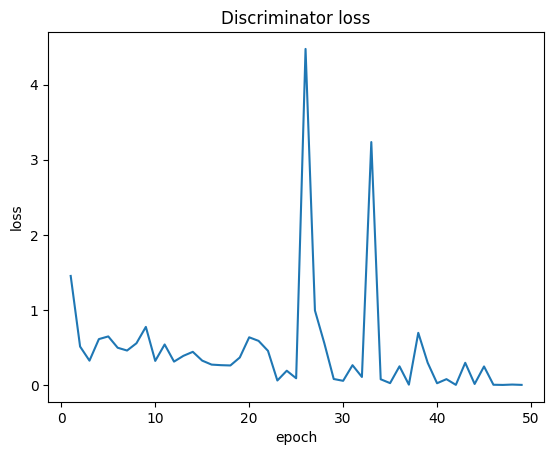

In [11]:
plt.plot([i for i in range(1, num_epochs)], [disc_loss[i*100] for i in range(0,49)])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Discriminator loss')
plt.show()

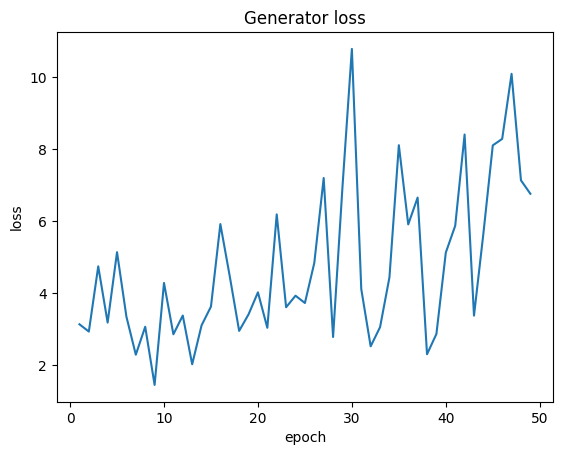

In [12]:
plt.plot([i for i in range(1, num_epochs)], [gen_loss[i*100] for i in range(0,49)])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Generator loss')
plt.show()

### 4.2 - Images Generated:

#### Epoch 0: 
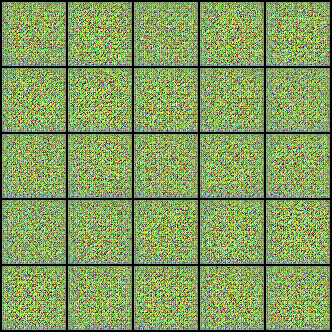

#### Epoch 12:
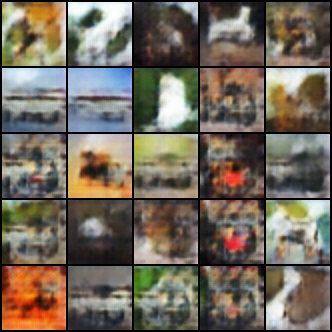

#### Epoch 25:
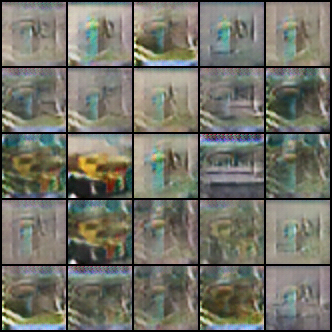

#### Epoch 37:
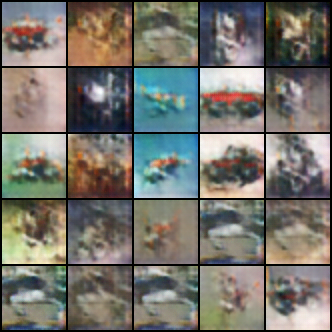

#### Epoch 50:
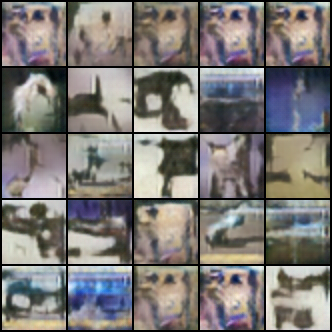

#### 4.3 - Discussion: 

DCGAN (Deep Convolutional Generative Adversarial Networks) is a type of GAN that uses convolutional neural networks (CNNs) for both the generator and the discriminator. DCGAN has both strengths and weaknesses, which are discussed below:

Good sides of DCGAN:

- Generates high-quality images: DCGAN is capable of generating high-quality images that are difficult to distinguish from real images. This is due to the use of CNNs, which are powerful deep learning models that can learn complex image features.
- Can generate diverse images: DCGAN can generate diverse images that capture the variability within the training data. This is due to the stochastic nature of the generator, which introduces randomness into the image generation process.
- Can learn from small datasets: DCGAN can learn from small datasets, such as CIFAR-10, and generate high-quality images. This is because the deep convolutional architecture of DCGAN can capture complex patterns in the data.

Bad sides of DCGAN:

- Can be difficult to train: DCGAN can be difficult to train, especially when the generator and discriminator architectures are not properly balanced. This can lead to problems such as mode collapse, where the generator produces limited variations of the same image, or vanishing gradients, which can slow down the learning process.
- Sensitive to hyperparameters: DCGAN is sensitive to hyperparameters, such as the learning rate, batch size, and number of training epochs. Choosing the wrong hyperparameters can lead to poor performance or slow convergence.
- Limited to generating images: DCGAN is limited to generating images and cannot be used for other types of data generation tasks, such as generating text or audio.
- In summary, DCGAN is a powerful deep learning model for generating high-quality images, but it requires careful tuning of hyperparameters and can be difficult to train.